In [19]:
#!/usr/bin/env python

import librosa 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np 
np.set_printoptions(precision=2,suppress=True)
from numpy import newaxis

import scipy
from librosa import display
import os
import subprocess
import glob
import tensorflow as tf
tf.python.control_flow_ops = tf


import time
import datetime

from keras.layers.core import Dense, Activation, Dropout 
from keras.layers.recurrent import LSTM 
from keras.models import Sequential
from keras.models import load_model 
from keras.layers import Dense, LSTM
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
import cwrnn # clockwork rnn 
from matplotlib.ticker import FormatStrFormatter

# set default matplotlib font 
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'

import warnings
warnings.filterwarnings('ignore')




In [149]:
# different model builds 
def build_model():
    model = Sequential()
    model.add(LSTM(256, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam') 
    return model

def build_stacked_model():
    model = Sequential()
    model.add(LSTM(100, input_shape=(x_train.shape[1], x_train.shape[2]),
                   return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(256, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam') 
    return model

def build_stateful_model(batch_size,x_shape_1,x_shape_2):
    model = Sequential()
    model.add(LSTM(16, 
                   batch_input_shape=(batch_size, x_shape_1, x_shape_2), 
                   stateful=True))
    model.add(Dropout(0.2))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam') 
    return model

def build_cwrnn_model():
    model = Sequential()
    model.add(cwrnn.ClockworkRNN(output_dim=108, 
                                 input_shape=(x_train.shape[1], x_train.shape[2]),
                                 period_spec=[1,2,4,16]))
    model.add(Dropout(0.2))
    
    model.add(Dense(y_train.shape[1], activation='sigmoid')) 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  
    return model


In [76]:
# get estimated bpm per FRAME --> dtempo
def constructbeats(tempovect):
    hop_length = 512.0 
    sr = 22050.0    
    total_num_frames = len(tempovect) # just over 1 second of frames
    frames_in_sec = sr/hop_length
    print 'size of beatframes', tempovect.shape
    tempovectinframes = tempovect/(60.0*frames_in_sec)
    beat = 0 
    beats = []   
    for i in range(len(tempovectinframes)):
        beat += tempovectinframes[i] # accumulate beatframe until reaching 1
        if beat >= 1.0:
            beats.append(i*hop_length)
            #print 'for bpm %r, create a beat at sample number %r' %(tempovect[i],hop_length*i)
            beat = 0        
    # return the sample numbers to place beat on top of
    return beats

In [116]:
# get all the spectral onsets 
def getallonsets(audiopath,binflag=False, thresh=0.0, d=10.0):
    onsetsarray = np.zeros((1,frames)) #1,477
    print '---the audio path: %r---'%(audiopath)
    
    for audio in glob.glob(audiopath+"/*.wav"):
        [y,sr] = librosa.load(audio, duration=d)
        print '...loading audio from %r...'%(audio)
        onset_env = librosa.onset.onset_strength(y) # extract onset envelope per frame

        onset_env /= max(onset_env) # normalize
        onset_env = np.around(onset_env,decimals=1) # squash into 0.1,0.2,0.3 increments
        if binflag==True:
            onset_env[onset_env<thresh]=0
            onset_env[onset_env>=thresh]=1
        
        # local tempo estimates
        tempframebuff = np.copy(onset_env)

        dtempo = librosa.beat.tempo(onset_envelope=onset,
                               aggregate=None)

        dtsamps = constructbeats(dtempo) # beat onsets to sample pos
        dtframes = librosa.samples_to_frames(dtsamps) # sample pos back to frame
        for frame in dtframes:
            tempframebuff[frame] = 1.0

        tempframebuff = np.reshape(tempframebuff,(1,len(tempframebuff)))

        #return tempframebuff        
        
        onsetsarray = np.concatenate((onsetsarray, tempframebuff))
        
    return onsetsarray[1:] # return all audio except empty vector at [0]

In [215]:
binflag=False
onsetsarr = getallonsets('./testaudio/',binflag=binflag, thresh=0.1)

---the audio path: './testaudio/'---
...loading audio from './testaudio/01.wav'...
size of beatframes (431,)
...loading audio from './testaudio/02.wav'...
size of beatframes (431,)
...loading audio from './testaudio/03.wav'...
size of beatframes (431,)
...loading audio from './testaudio/04.wav'...
size of beatframes (431,)
...loading audio from './testaudio/05.wav'...
size of beatframes (431,)
...loading audio from './testaudio/06.wav'...
size of beatframes (431,)
...loading audio from './testaudio/07.wav'...
size of beatframes (431,)
...loading audio from './testaudio/08.wav'...
size of beatframes (431,)
...loading audio from './testaudio/09.wav'...
size of beatframes (431,)


In [78]:
# TENSOR SHAPING:
# 20 frames is about 0.5 seconds so predictions will take into account past 0.5 seconds
# need to mess with this number
def format_data(beatvector, seq_len=20,binflag=True): 
    dims = 10.0
    data = np.copy(beatvector)
    
    sequence_length = seq_len # window size
    result = []
    for index in range(len(data)-sequence_length):
        result.append(data[index: index + sequence_length]) # operating over 50 samples, moving one sample ahead
        
    result = np.array(result) 
    
    row = np.array(result) 
    percent_train = 0.9 # how much to train, remainder is for validation 
    row = round(percent_train * result.shape[0]) 
    train = result[:row,:] 
    #np.random.shuffle(train) 
    x_train = train[:,:-1] # all except last entry in seq
    y_train = train[:,-1] # last entry, 'target'

    if binflag==False:
        y_train *= (dims-1) # create 10 dimensions for output [0.0, 0.1,..,1.0] 
        y_train = np.around(y_train) # round into integer for categorical rep

    x_test = result[row:, :-1]
    y_test = result[row:, -1]
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
    #print y_train.shape
    
    # for softmax
    y_train = np_utils.to_categorical(y_train,dims)
    y_test = np_utils.to_categorical(y_test,dims)

    #print y_train[0:10]
    
    return [x_train, y_train, x_test, y_test]

In [216]:
dur = 10.0 # 10 seconds
sr = 22050
hop_length = 512
frames = np.ceil(sr*dur/hop_length)
print frames
frames = int(np.ceil(sr*dur/hop_length))
print frames



431.0
431


In [219]:
# stop after loss is below some threshhold val
# from keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=2)
# model.fit(X, y, valrint onsetsarr[0]

In [220]:
# PARAMS
#{ Clockwork RNN, SCALED RNN, Binary RNN}
modeltype='Clockwork RNN'

if modeltype=='Binary RNN':
    binflag=True
else:
    binflag=False
print binflag
# get all the onsets
onsetsarr = getallonsets('./testaudio/',binflag=binflag, thresh=0.1)

# set seq_len window size
seq_len = 20 # this is the number of timesteps it slices the beat onset vectors
             # into. Therefore, it's using seq_len timesteps to predict 
             # the seq_len+1 value. How far back it's looking to infer beat

# grab an onset vector to get appropriate dimensions 
x_train, y_train, x_test, y_test = format_data(onsetsarr[0], 
                                               seq_len, binflag=binflag)
#print x_train.shape, y_train.shape
# create buffers to hold and accumulate beat onset arrays
x_tr = np.zeros((x_train.shape[0],x_train.shape[1],x_train.shape[2])) 
y_tr = np.zeros((y_train.shape[0],y_train.shape[1]))


# stack formated beat onset arrays from each onset in the onset array
for i,onset in enumerate(onsetsarr):
    [x_train, y_train, x_test, y_test] = format_data(onset,
                                                     seq_len,binflag=binflag)
    x_tr = np.vstack((x_tr,x_train))
    y_tr = np.vstack((y_tr,y_train))

# sanity check dimensions 
print 'x_tr:', x_tr.shape, 'y_tr:', y_tr.shape 

False
---the audio path: './testaudio/'---
...loading audio from './testaudio/01.wav'...
size of beatframes (431,)
...loading audio from './testaudio/02.wav'...
size of beatframes (431,)
...loading audio from './testaudio/03.wav'...
size of beatframes (431,)
...loading audio from './testaudio/04.wav'...
size of beatframes (431,)
...loading audio from './testaudio/05.wav'...
size of beatframes (431,)
...loading audio from './testaudio/06.wav'...
size of beatframes (431,)
...loading audio from './testaudio/07.wav'...
size of beatframes (431,)
...loading audio from './testaudio/08.wav'...
size of beatframes (431,)
...loading audio from './testaudio/09.wav'...
size of beatframes (431,)
x_tr: (3700, 19, 1) y_tr: (3700, 10)


In [ ]:
# STATEFUL LSTM RNN
batch_size = 1
xshape1 = x_tr.shape[1]
xshape2 = x_tr.shape[2]
print xshape1 
print xshape2 
model = build_stateful_model(batch_size, xshape1, xshape2)

# call back function to save weights after every epoch (or iteration through batch here)
filepath="./audio-weights/weights-improvement-{epoch:02d}-{loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

loss = []
num_seq = 150

for i in range(num_seq):
    print '... running batch %r/%r...' %(i,num_seq)
    history = model.fit(x_tr,y_tr, nb_epoch=1, batch_size=batch_size,
             verbose=2, shuffle=False, callbacks=callbacks_list)
    loss.append(history.history['loss'])
    model.reset_states()

In [199]:
# stateless LSTM RNN
# call back function to save weights after every epoch (or iteration through batch here)


epochs = 200
model = build_model()

history = model.fit(x_tr,y_tr, nb_epoch=epochs, batch_size=100)

Epoch 1/200
3700/3700 [==============================] - 4s - loss: 0.7611     

In [221]:

if modeltype =='Clockwork RNN':
    rootdir = './CW/'
    itersdir = rootdir + 'seqs'+ str(seq_len)+'/'
    if not os.path.exists(itersdir):
        os.makedirs(itersdir)
    plotdir = itersdir  
    kitersdir = rootdir + 'pdfs'+ str(seq_len)+'/'
    if not os.path.exists(kitersdir):
        os.makedirs(kitersdir)    
    kdedir = kitersdir
if modeltype =='Scaled RNN':
    rootdir = './scaled/'    
    itersdir = rootdir + 'seqs'+ str(seq_len)+'/'
    if not os.path.exists(itersdir):
        os.makedirs(itersdir)
    plotdir = itersdir    
    kitersdir = rootdir + 'pdfs'+ str(seq_len)+'/'
    if not os.path.exists(kitersdir):
        os.makedirs(kitersdir)    
    kdedir = kitersdir
if modeltype=='Binary RNN':
    rootdir = './binary/'
    itersdir = rootdir + 'seqs'+ str(seq_len)+'/'
    if not os.path.exists(itersdir):
        os.makedirs(itersdir)
    plotdir = itersdir    
    kitersdir = rootdir + 'pdfs'+ str(seq_len)+'/'
    if not os.path.exists(kitersdir):
        os.makedirs(kitersdir)    
    kdedir = kitersdir
else:
    print 'please input a valid modeltype'

print 'DIRECTORIES SANITY CHECK'
print "rootdir:", rootdir
print 'plotdir:', plotdir 
print 'kdedir:', kdedir 
    


please input a valid modeltype
DIRECTORIES SANITY CHECK
rootdir: ./CW/
plotdir: ./CW/seqs20/
kdedir: ./CW/pdfs20/


In [242]:
#model = build_cwrnn_model()
#epochs = 200 
history = model.fit(x_train,y_train, nb_epoch=epochs, batch_size=20)
print 'done'

Epoch 1/200
370/370 [==============================] - 0s - loss: 0.1515 - acc: 0.9378     
Epoch 2/200
370/370 [==============================] - 0s - loss: 0.1343 - acc: 0.9486     

In [ ]:
# 2 hidden layers
model = build_stacked_model()
print model.summary()
history = model.fit(x_train,y_train, nb_epoch=200, batch_size=20)
print 'done'

In [170]:
# save weights
model.save(rootdir + 'weights/' + str(epochs) + 'epochs' + str(seq_len)+'_'+ modeltype +'.h5')
#run some more?
#model.fit(x_train,y_train, nb_epoch=200, batch_size=20)



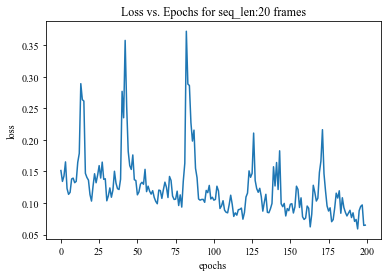

In [243]:
plt.figure() 
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss vs. Epochs for seq_len:' + str(seq_len) + ' frames')
#plt.savefig(rootdir + modeltype + ' loss' + str(epochs) + 'epochs' + '.png')


#now = datetime.datetime.now()
#fname = now.strftime("%Y-%m-%d_%H:%M_" + str(epochs))

#plt.savefig('./plots/'+fname + '.png')
plt.show()

In [119]:
# # for stateful loss plottin
# plt.figure() 
# plt.plot(loss)
# plt.savefig('')
# plt.xlabel('epochs')
# plt.ylabel('loss')
# #now = datetime.datetime.now()
# #fname = now.strftime("%Y-%m-%d_%H:%M_" + str(epochs))

# #plt.savefig('./cw-plots/'+'400epochs_cw_rnn' + '.png')
# plt.show()

In [ ]:
# save the model weights
# tho can't save the CWRNN weights...
model.save(rootdir + './weights/'+ str(epochs) +'epochs-ns-scaled' + '.h5')

In [181]:
# load a model 
model = load_model('./scaled/weights/'+ '200Scaled RNN' + '.h5')

In [213]:
def predict_point(model, data):
    #predict each timestep given the last sequence of the true data
    predicted = model.predict(data) 
    predicted = np.reshape(predicted, (predicted.size,)) 
    return predicted 

In [233]:
def predict_sequence(model, data, window_size, noiters, binflag=False):
    # shift window by 1 new prediction each time, re-run prediction on window 
    curr_frame = data[0] # this will be X_test data
    predicted = []
    thresh = 0.5
    for i in xrange(noiters):
        #print curr_frame[:,0]
        predpt = model.predict(curr_frame[newaxis,:,:])#[0,0]
        #print 'predpt',predpt
        predpt = np.argmax(predpt) # choose index that is larger
        #print '\t choose', predpt
        if binflag == True:
            if (predpt > thresh):
                predpt = 1.0
            elif (predpt <= thresh):
                predpt = 0.0
        elif binflag == False:
            predpt /= 10.0 

        predicted.append(predpt)
        #print curr_frame[newaxis,:,:][0,0]
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, window_size-1, predicted[-1], axis=0)
    return predicted



In [120]:
# to load weights from prior model  
# import keras
# oldmodel = keras.models.load_model('./weights/09_1000-e.h5')


In [130]:
xprobe = x_test[2]
xprobe = np.reshape(xprobe,(1,19,1))

print 'softmax output of y_test[1]\n', y_test[1]

#xprobe = np.reshape(xprobe,(1,xprobe.shape[0],xprobe.shape[1]))
#print xprobe
predpt = predict_point(model,xprobe)
#print 'predicted point', predpt
predindex = np.argmax(predpt)

predicted_ = np.insert(xprobe,len(xprobe[0]),predindex)

#print 'now new beat vector is\n',predicted_
# plt.figure()
# plt.stem(predicted_)
# plt.show()

softmax output of y_test[1]
[1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]


In [144]:
print x_test.shape

(33, 99, 1)


In [185]:
# evaluate predicted point across all testing examples 

corr = 0
wr = 0
for i in range(len(x_test)):
    xprobe = x_test[i]
    xprobe = np.reshape(xprobe,(1,seq_len-1,1))
    predpt = predict_point(model,xprobe)
    #print 'predicted point', predpt
    #print 'actual point', y_test[i]
    choice = np.argmax(predpt)
    actualchoice = np.argmax(y_test[i])
    if choice==actualchoice:
        #print 'correct'
        corr += 1.
    else: 
        #print 'wrong'
        wr += 1.
    
print 'total percent correct=',100*corr/len(x_test), '%'

#total percent correct= 0.878048780488
# 400 epoch - cw scaled : total % correct: %73


total percent correct= 74.358974359 %


In [ ]:
plt.figure()
plt.stem(predicted_,linewidth='0.5')
plt.ylim([0,1.5])
plt.show()

In [238]:
seqsdir = rootdir + 'seqs'+ str(gen_length) + '/'
pdfsdir = rootdir + 'pdfs' + str(gen_length) + '/'
print seqsdir, pdfsdir

./CW/seqs200/ ./CW/pdfs200/


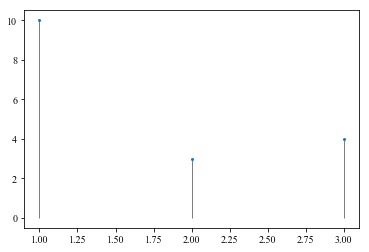

In [333]:
plt.figure()

x = np.array([1,2,3])
data = np.array([10,3,4])
plt.vlines(x, 0, data, linewidth='0.5')
plt.plot(x, data,'o',markersize=2)
plt.show()


rootdir: ./CW/
sequence plots dir: ./CW//seqs300/
pdfs plots dir: ./CW//pdfs300/
.........0............


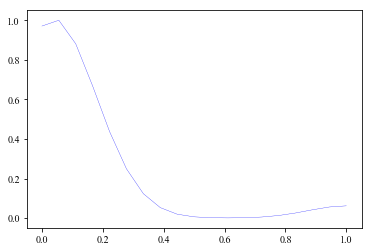

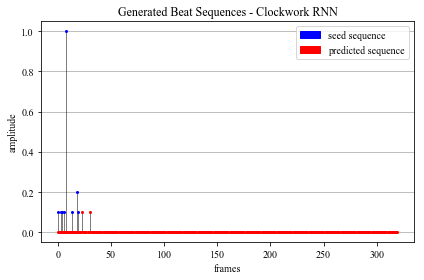

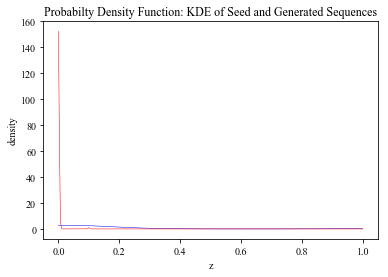

.........1............


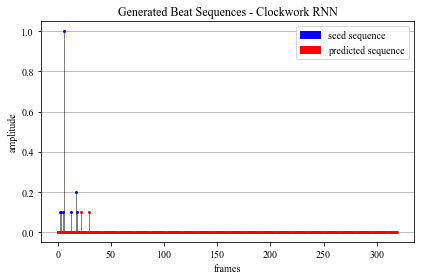

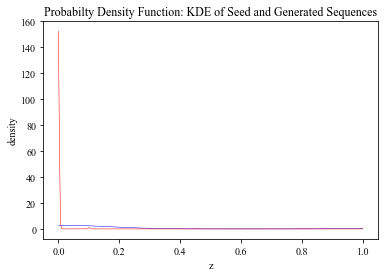

.........2............


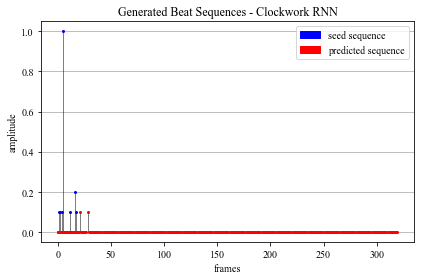

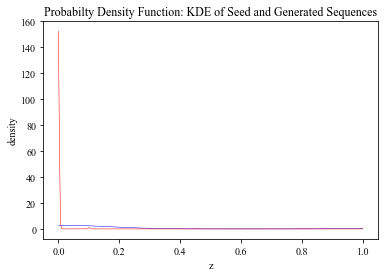

.........3............


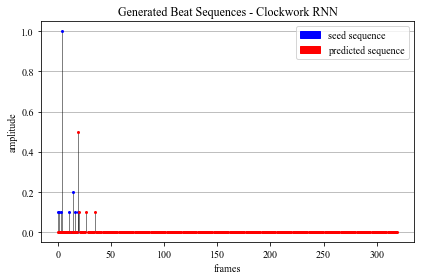

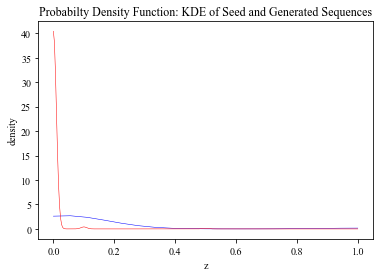

.........4............


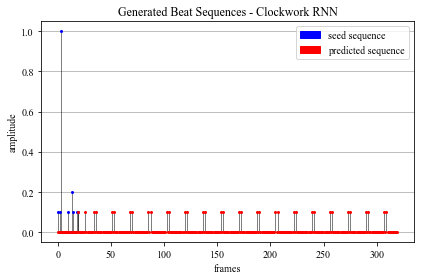

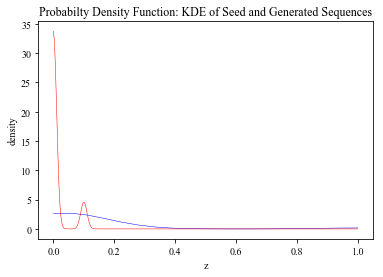

.........5............


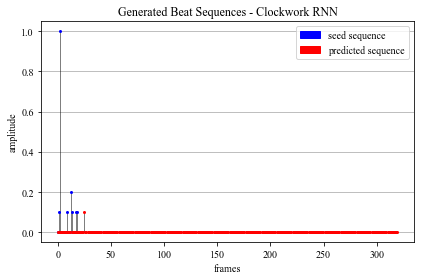

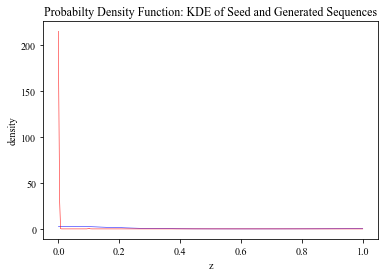

.........6............


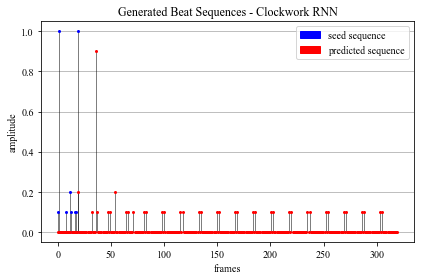

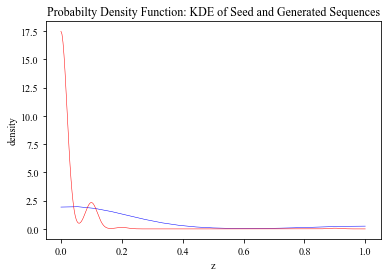

.........7............


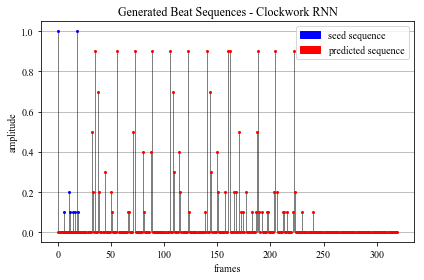

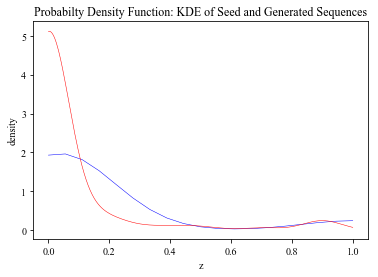

.........8............


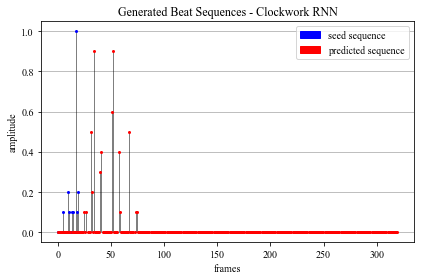

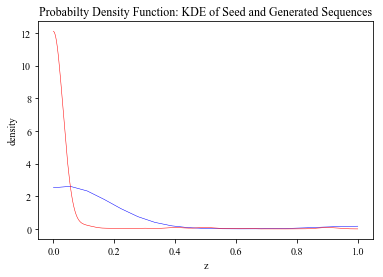

.........9............


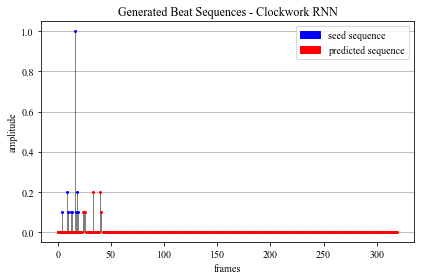

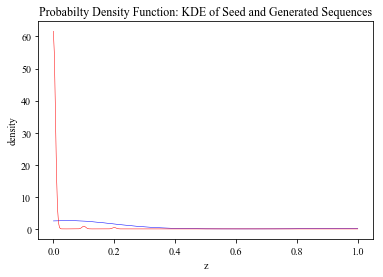

.........10............


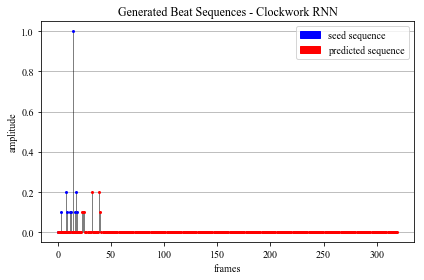

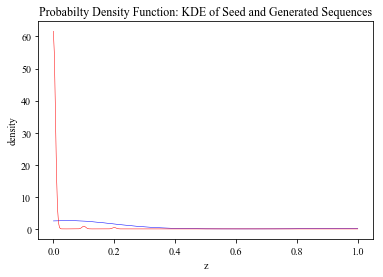

.........11............


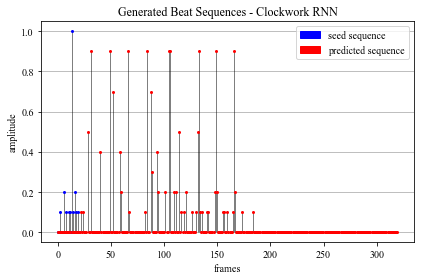

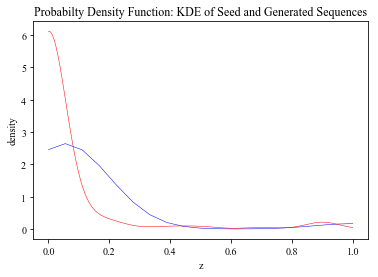

.........12............


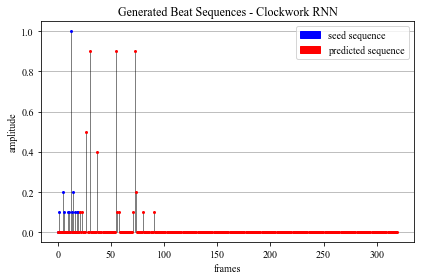

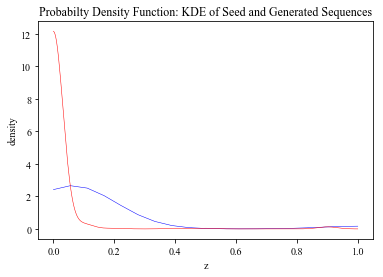

.........13............


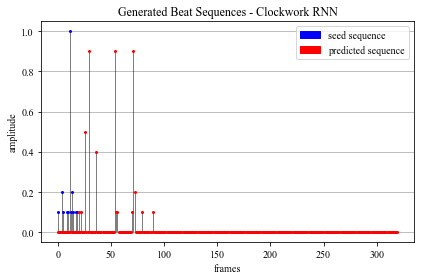

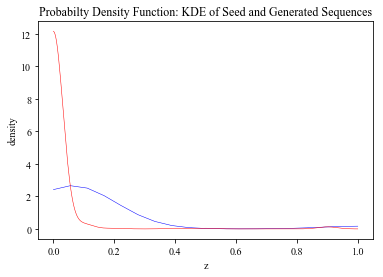

.........14............


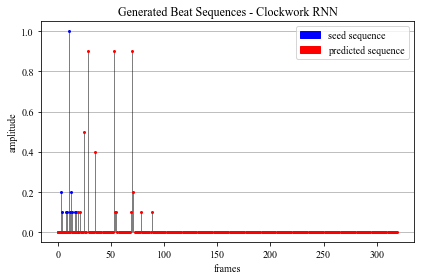

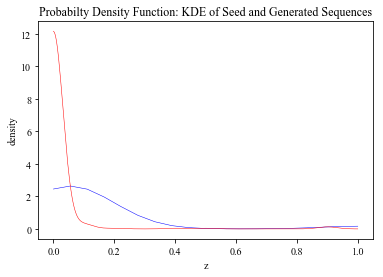

.........15............


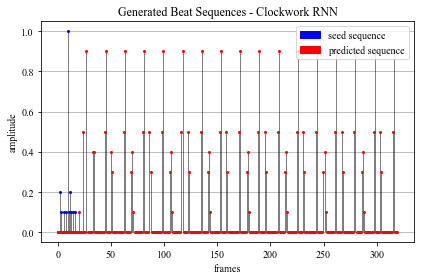

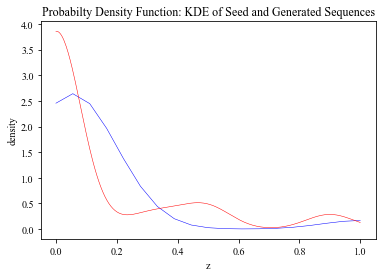

.........16............


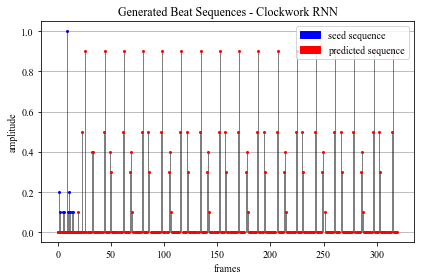

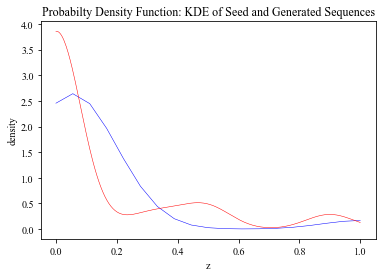

.........17............


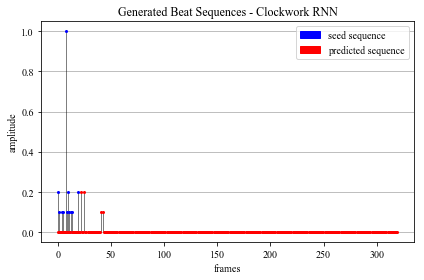

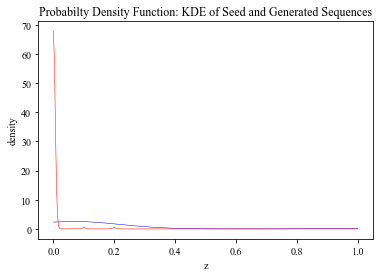

.........18............


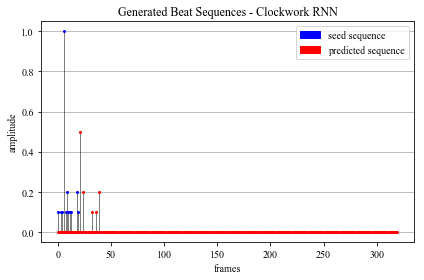

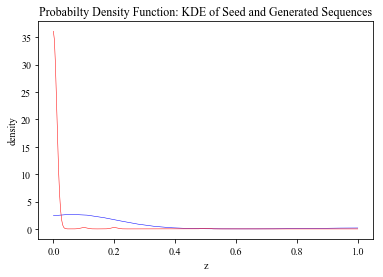

.........19............


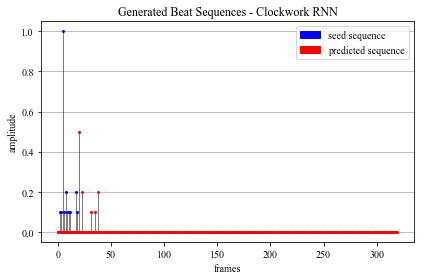

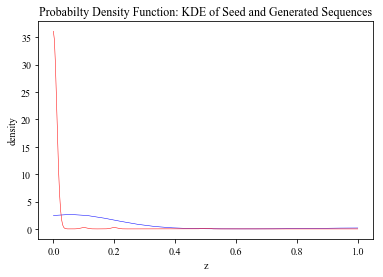

.........20............


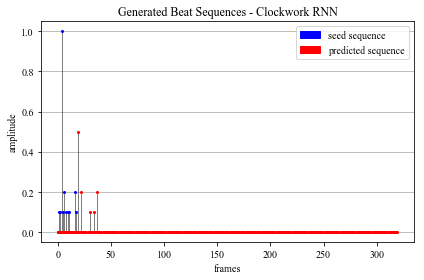

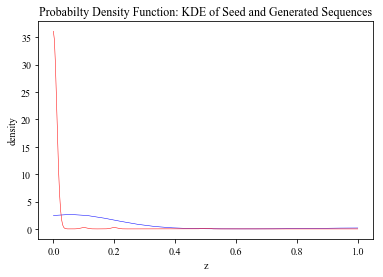

.........21............


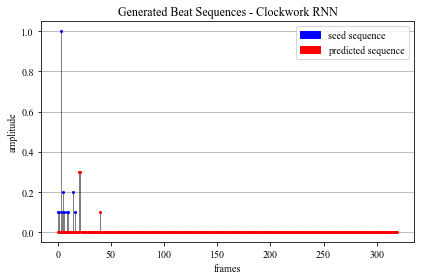

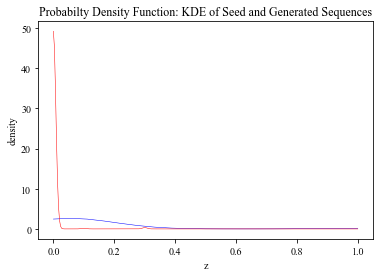

.........22............


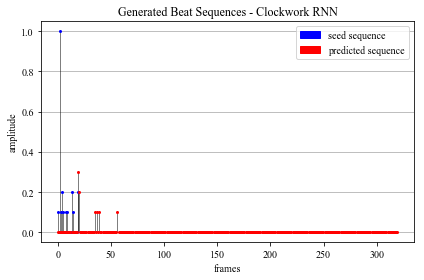

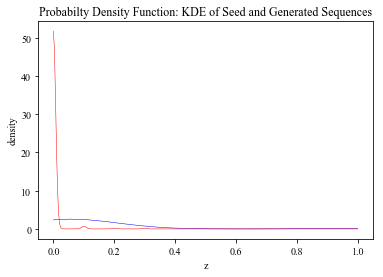

.........23............


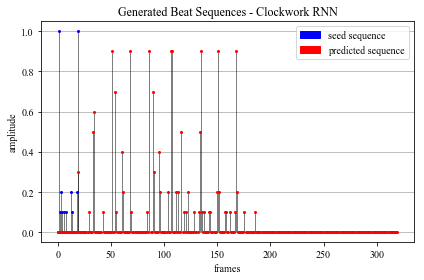

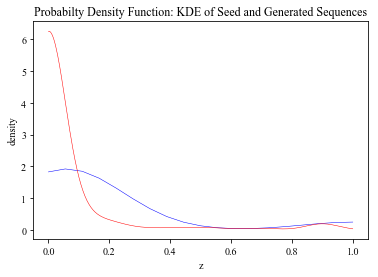

.........24............


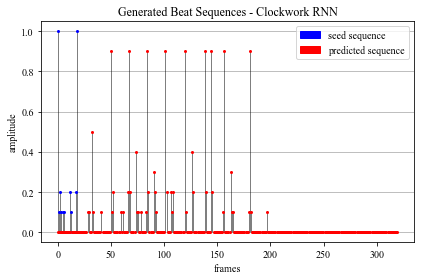

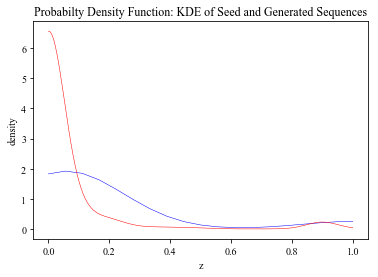

.........25............


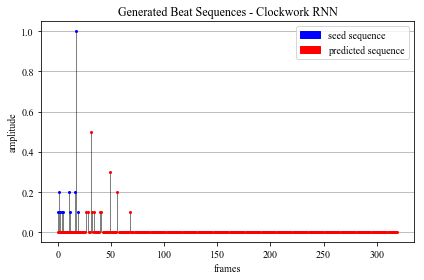

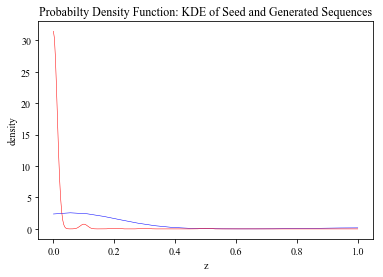

.........26............


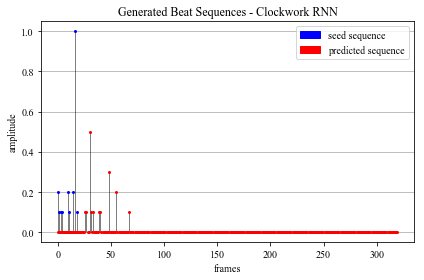

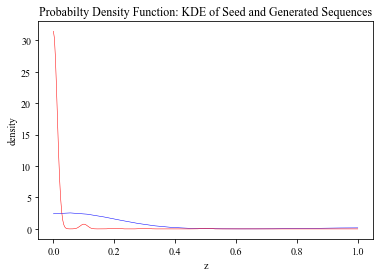

.........27............


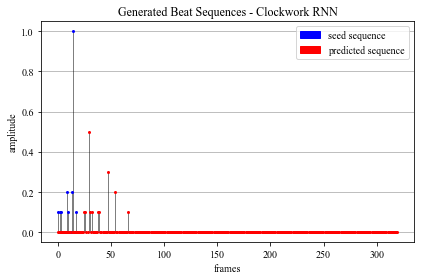

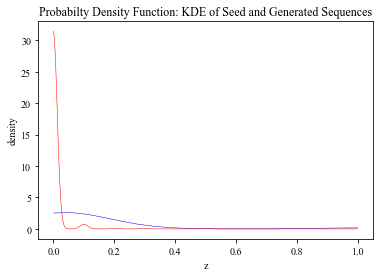

.........28............


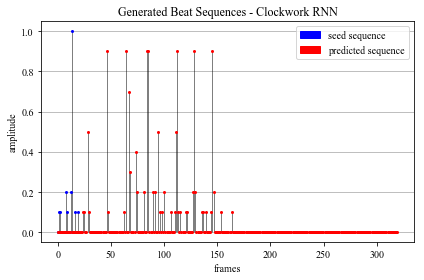

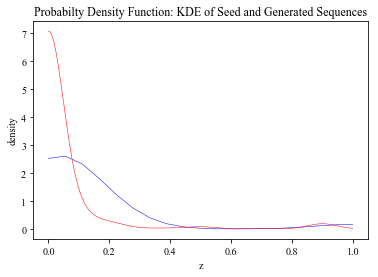

.........29............


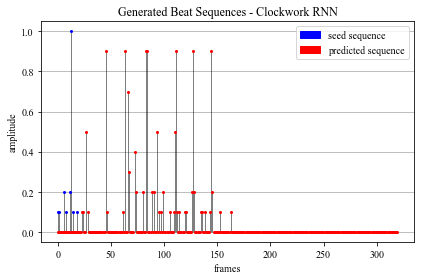

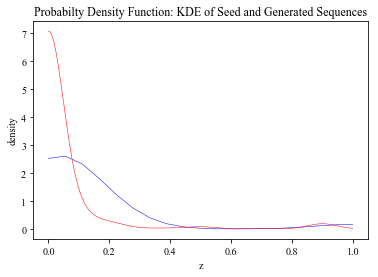

.........30............


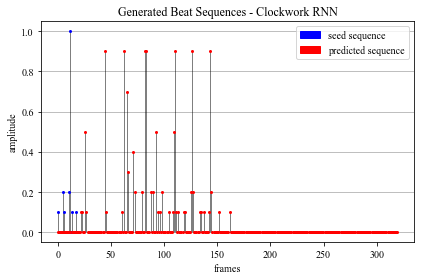

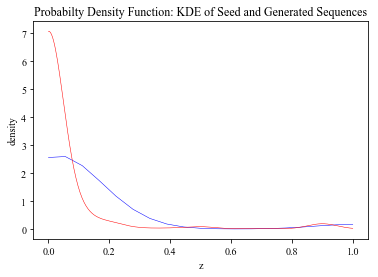

.........31............


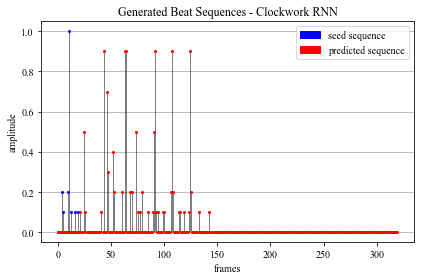

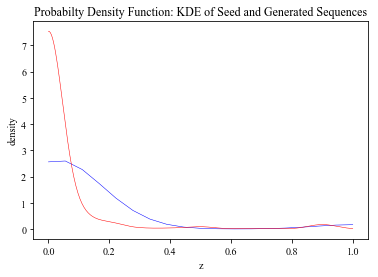

.........32............


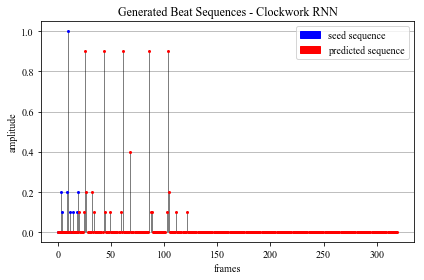

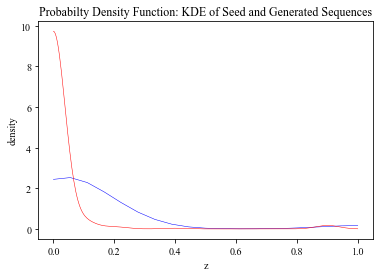

.........33............


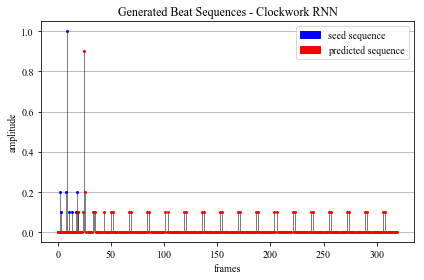

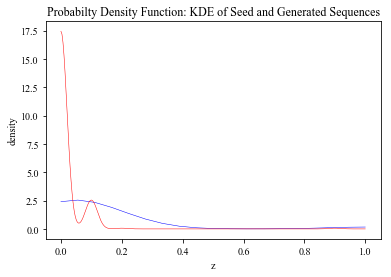

.........34............


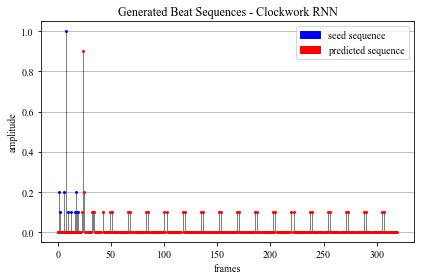

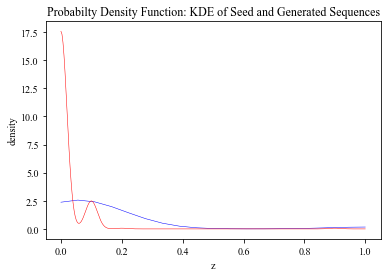

.........35............


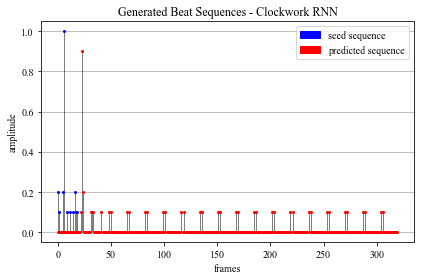

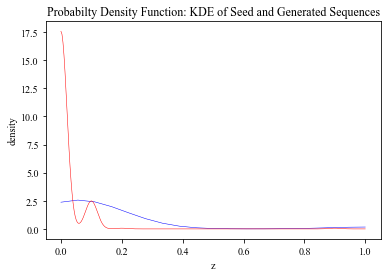

.........36............


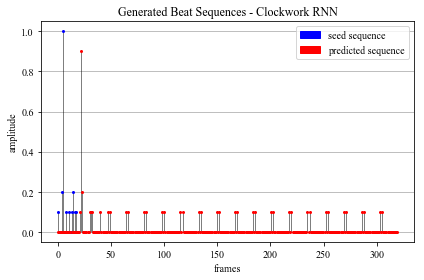

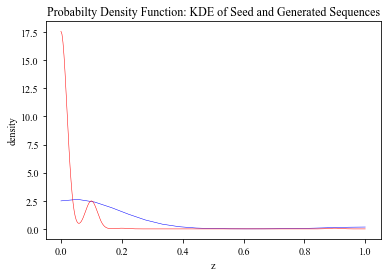

.........37............


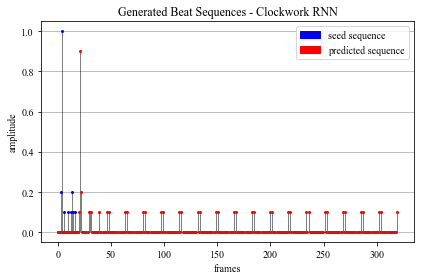

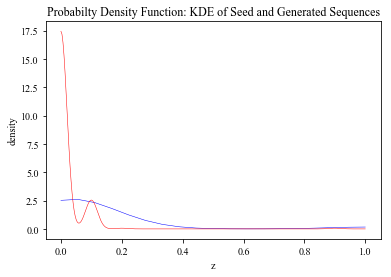

.........38............


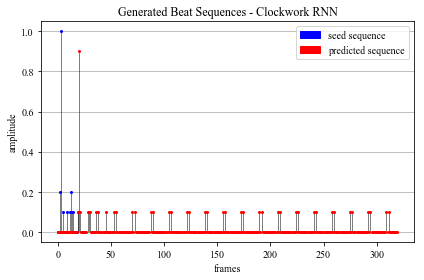

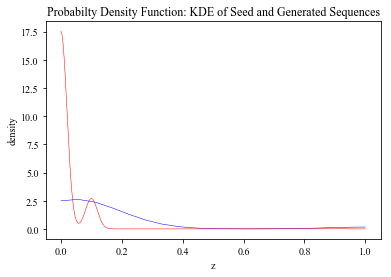

.........39............


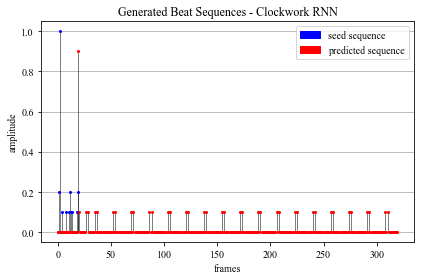

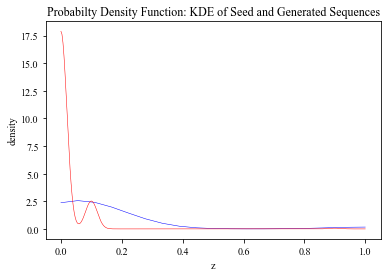

.........40............


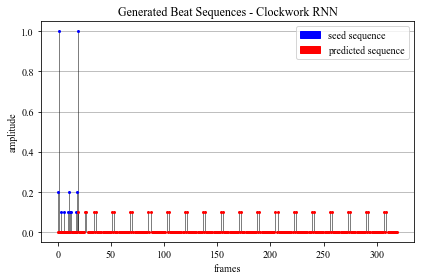

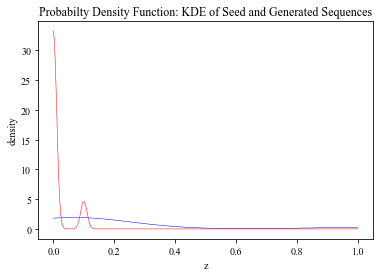

(41, 19)
(41, 300)


ValueError: x and y must have same first dimension, but have shapes (19,) and (300,)

In [346]:
## PLOTTING
numsubplots = len(x_test)

# please input a valid modeltype
# DIRECTORIES SANITY CHECK
# rootdir: ./CW/
# plotdir: ./CW/seqs20/
# kdedir: ./CW/pdfs20/

# float_formatter = lambda x: "%.2f" % x
# np.set_printoptions(formatter={'float_kind':float_formatter})

# modeltype = 'Clockwork RNN'
# modeltype = 'LSTM RNN'

    
numsubplots = len(x_test)
gen_length = 300# seq_len-1 will produce accumulated PDF plot, otherwise mismatched shapes

seqsdir = rootdir + '/seqs'+ str(gen_length) + '/'
pdfsdir = rootdir + '/pdfs' + str(gen_length) + '/'
if not os.path.exists(seqsdir):
    os.makedirs(seqsdir)    
    plotdir = seqsdir
if not os.path.exists(pdfsdir):
    os.makedirs(pdfsdir)
    kdedir = pdfsdir

print "rootdir:", rootdir 
print 'sequence plots dir:', plotdir 
print 'pdfs plots dir:', kdedir

sumseed = []
sumpred = []

for i in range(0,numsubplots):
    print '.........%r............' %(i)
    xprobe = x_test[i]
    xprobesh = np.reshape(xprobe,(1,seq_len-1,1))
    predseq = predict_sequence(model,xprobesh,seq_len-1,gen_length)
    # concatenate predicted sequence from
    # xprobe with the predictions from that seed
    zeros = np.zeros(len(xprobe))
    catseq = np.concatenate((zeros,predseq),axis=0)

    plotseqs(xprobe, catseq, plotdir)
    [kdeseed, kdepred] = plotkde(xprobe[:,0],predseq,i)
    
    sumseed.append(kdeseed)
    sumpred.append(kdepred)

sumseed = np.asarray(sumseed)
sumpred = np.asarray(sumpred)

print sumseed.shape
print sumpred.shape

plt.figure()
dist_space = np.linspace(np.min(sumseed[2]),np.max(sumseed[2]),len(sumseed[2]))    
dist_space = np.linspace(0,1,len(sumseed[2])) 

maxval = max(np.max(sumseed,axis=0))
sumseed[:,] /= maxval

maxval = max(np.max(sumpred,axis=0))
sumpred[:,] /= maxval


for s,p in zip(sumseed,sumpred):
    plt.plot(dist_space, s,'b',alpha=0.9, linewidth='0.3')
    plt.plot(dist_space, p,'r',alpha = 0.9, linewidth='0.3')

redpatch = mpatches.Patch(color='blue', label='seed sequences')
bluepatch = mpatches.Patch(color='red', label='predicted sequences')
plt.legend(handles=[redpatch,bluepatch])
plt.xlabel('z')
plt.ylabel('Normalized Beat Onset Density')
plt.title(modeltype + ' PDF Kernel Density Estimation: Seed and Generator')
plt.savefig(rootdir + 'seqlen-'+ str(seq_len) + '-cum_PDF_KDE.pdf')
plt.show()
print 'done'
# plt.tight_layout()
#plt.show()

#plt.show()

print 'doneskies'
'''
Qs:
it will generate 'interesting' output for several timesteps but then tends to 
repeating 1s or 0s after some point. it's l
'''

In [39]:
print np.max(sumseed,axis=0)
maxval = max(np.max(sumseed,axis=0))
sumseed[:,] /= maxval

print sumseed[:,]

[1.00 0.95 0.82 0.65 0.50 0.42 0.40 0.43 0.46 0.46 0.43 0.37 0.29 0.21 0.15
 0.11 0.09 0.09 0.08]
(3, 19)
[[0.91 0.87 0.76 0.62 0.49 0.42 0.40 0.43 0.46 0.46 0.43 0.37 0.29 0.21
  0.15 0.11 0.09 0.09 0.08]
 [1.00 0.95 0.82 0.65 0.50 0.40 0.36 0.37 0.39 0.39 0.37 0.31 0.24 0.17
  0.13 0.10 0.09 0.08 0.08]
 [1.00 0.95 0.82 0.65 0.50 0.40 0.36 0.37 0.39 0.39 0.37 0.31 0.24 0.17
  0.13 0.10 0.09 0.08 0.08]]


In [345]:
from scipy.stats.kde import gaussian_kde 
from numpy.linalg import LinAlgError

def plotseqs(zerovect, seqvect, thedir):
    plt.figure()

#     mline, stemline, bline = plt.stem(zerovect)
#     plt.setp(stemline, linewidth=0.5,color='b')
#     mline, stemline, bline = plt.stem(seqvect)
#     plt.setp(stemline, linewidth=0.5,color='r')

    x = np.linspace(0,len(zerovect),len(zerovect))
    data = np.array([10,3,4])
    plt.vlines(x, 0, zerovect, linewidth='0.5')
    plt.plot(x, zerovect,'bo',markersize=2)
    x = np.linspace(0,len(seqvect),len(seqvect))

    
    plt.vlines(x, 0, seqvect, linewidth='0.5')
    plt.plot(x, seqvect,'ro',markersize=2)
    
    ax = plt.gca()
    ax.grid()
    

    

#     ax.stem(xprobe,color='b')
#     ax.stem(catseq,color='r')

    plt.xlabel('frames')
    plt.ylabel('amplitude')
    title = 'Generated Beat Sequences - ' + modeltype
    plt.title(title)
    redpatch = mpatches.Patch(color='blue', label='seed sequence')
    bluepatch = mpatches.Patch(color='red', label='predicted sequence')

    plt.legend(handles=[redpatch,bluepatch])

    ax = plt.gca()
    ax.grid(True)
    ax.xaxis.grid(False)

    plt.tight_layout()

    now = datetime.datetime.now()
    fname = now.strftime("_%Y-%m-%d %H:%M")
    
    plt.savefig(plotdir + title.replace(' ','') + '_' + str(i)+'.png')
   
    plt.show()

# density statistic
def plotkde(seed, pred, k):
    #print seed, pred
    try:
        kde_seed = gaussian_kde(seed)
        kde_pred = gaussian_kde(pred)

        dist_space_seed = np.linspace(np.min(seed),np.max(seed),len(seed))    
        dist_space_pred = np.linspace(np.min(pred),np.max(pred),len(pred))
        
        dist_space_seed /= max(dist_space_seed)
        dist_space_pred /= max(dist_space_pred)

        #print kde_seed(dist_space_seed),kde_pred(dist_space_pred)
        pdfseed = kde_seed(dist_space_seed)
        pdfpred = kde_pred(dist_space_pred)

        plt.figure()
        plt.plot(dist_space_seed, pdfseed,'b', linewidth='0.5')
        plt.plot(dist_space_pred, pdfpred,'r', linewidth='0.5')

    except LinAlgError:
        pdfpred = np.zeros(len(pred))
        pdfseed = np.zeros(len(seed))
    
    plt.xlabel('z')
    plt.ylabel('density')
    plt.title('Probabilty Density Function: KDE of Seed and Generated Sequences')
    #plt.ylim([0,1])

    #plot.stem(probe)
    plt.savefig(kdedir + str(k) + '.png')
    plt.show()
    
    return [pdfseed,pdfpred]

In [ ]:
# look at test/train set
for i in range(10):
    plt.figure()
    plt.stem(x_train[i])
    plt.show()


In [ ]:
# TO DO:
# formulate a density statistic 
# given test set of 20 samples, and predicted sequence of 20,40 time steps 
# how closely correlated are the input sequences with the predicted sequences
# in terms of SPARSITY

size of beatframes (431,)
dtsamps [16896.0, 34304.0, 51712.0, 65536.0, 75264.0, 84992.0, 95744.0, 109568.0, 123392.0, 137216.0, 151040.0, 164864.0, 178688.0, 192512.0, 200192.0, 205824.0, 211456.0, 217088.0]
dtframes [ 33  67 101 128 147 166 187 214 241 268 295 322 349 376 391 402 413 424]


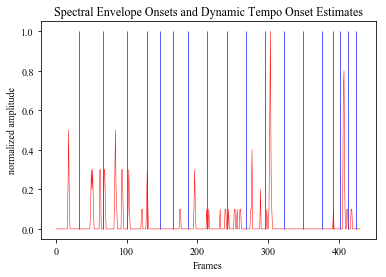

In [75]:
# dtsamps = constructbeats(dtempo)
# dtframes = librosa.core.samples_to_frames(dtsamps)

def overlay_tempo_onsets(onset):
    # initialize array
    tempframebuff = np.copy(onset)
    #plt.figure()
    #plt.plot(onset,'r',linewidth='0.5')
    # get dynamic tempo
    dtempo = librosa.beat.tempo(onset_envelope=onset,
                           aggregate=None)


    dtsamps = constructbeats(dtempo) # beat onsets to sample pos
    print 'dtsamps',dtsamps
    dtframes = librosa.samples_to_frames(dtsamps) # sample pos back to frame
    print 'dtframes',dtframes
    
    for frame in dtframes:
        tempframebuff[frame] = 1.0

#     plt.vlines(dtframes, 0, 1, color='b', alpha=0.8, linewidth='0.8')
#     plt.xlabel('Frames')
#     plt.ylabel('normalized amplitude')
#     plt.title('Spectral Envelope Onsets and Dynamic Tempo Onset Estimates')
#     plt.savefig('./auxplots/spect_tempo_onsets.pdf')
#     plt.show()
    return tempframebuff

beats = overlay_tempo_onsets(onsetsarr[0])